In [1]:
include("src/cpa.jl")

run_method (generic function with 1 method)

In [2]:
nq = 9
steps = 7
T = steps/20
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  #abs(h) < abs(J) in ordered phase
angle_definition = pi/20
trotter = trotter_setup(nq, steps, T, J, h);
observable= obs_interaction(trotter);
min_abs_coeff = 0.0;

# Plain CDR
- Target data (exact and noisy)

In [3]:
exact_expval_target = trotter_time_evolution(trotter; observable = observable, record=true, min_abs_coeff=min_abs_coeff,max_weight = Inf);

In [4]:
noisy_expval_target = trotter_time_evolution(trotter; observable = observable, noise_kind="gate_ising", record=true, min_abs_coeff=min_abs_coeff);

In orange, we plot the time evolution we want to correct. In blue, we see the exact evolution using PauliPropagation.

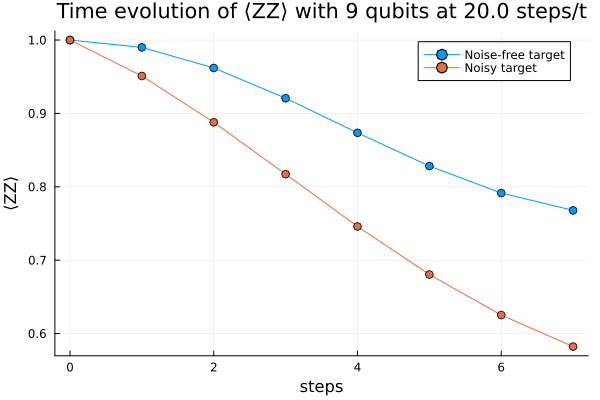

In [5]:
plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
elseif observable == obs_magnetization(trotter)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

### Training data
- create a training set using one of the predefined methods, here the CPA "loose" method

In [6]:
list_training_thetas = training_set_generation_loose_perturbation(trotter;sample_function = "small",num_samples=10);

In [7]:
exact_expvals_training = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, record=true);

In [8]:
noisy_expvals_training = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, noise_kind="gate_ising", record = true);

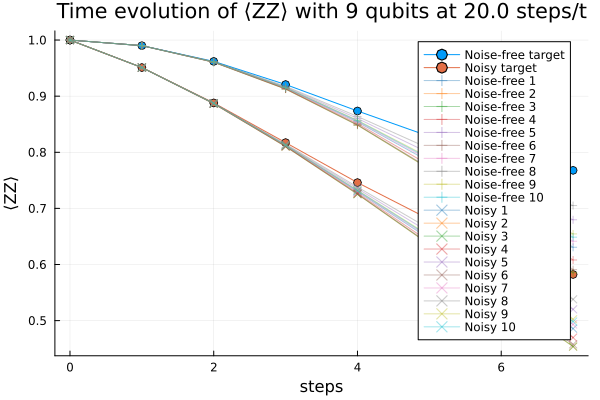

In [9]:
colors = palette(:tab10)

plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

for (i, exact) in enumerate(exact_expvals_training)
    plot!(0:trotter.steps, exact, label="Noise-free $(i)", c=colors[i], marker=:+, alpha = 0.4)
end

for (i, noisy) in enumerate(noisy_expvals_training)
    plot!(0:trotter.steps, noisy, label="Noisy $(i)", color=colors[i], marker=:x, alpha = 0.4)
end

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
else
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

### CDR
1) considering only the last step
2) CDR with decaying weights

In [10]:
# CDR considering only last step
corrected, rel_after, rel_before = cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target; exact_target_exp_value = exact_expval_target, use_target=true
)

#CDR with decaying weights
decay_weights = [
    [τ == t ? 1.0 : (τ == t-1 ? 0.5 : 0.0) for τ in 1:t]
    for t in 1:length(noisy_expvals_training[1])
]
corrected_weight, rel_after_weight, rel_before_weight = cdr(
    noisy_expvals_training,
    exact_expvals_training,
    noisy_expval_target, decay_weights; exact_target_exp_value = exact_expval_target, use_target=true
);

println("Relative error before CDR: ", rel_before)
println("Relative error after CDR: ", rel_after[end])
println("Relative error after CDR with decay weights: ", rel_after_weight[end])

Relative error before CDR: [0.0, 0.03940399000000007, 0.07690916982183928, 0.11241871344464158, 0.1461073864499863, 0.17844695913209901, 0.210106717512654, 0.24169264147375977]
Relative error after CDR: 0.024939523011900208
Relative error after CDR with decay weights: 0.04161704791365465


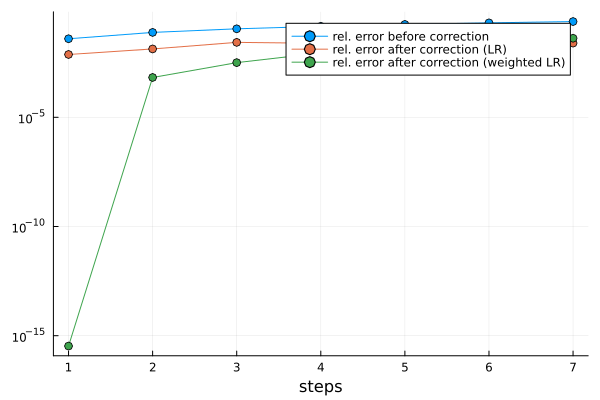

In [11]:
plot(1:trotter.steps, rel_before[2:end], xlabel="steps", label="rel. error before correction", marker=:o)
plot!(1:trotter.steps, rel_after[2:end], label="rel. error after correction (LR)", marker=:o)
plot!(1:trotter.steps, rel_after_weight[2:end], label="rel. error after correction (weighted LR)", marker=:o, yscale=:log10,legend=:best)

# Plain ZNE
- for last step/ all steps

In [12]:
noisy_expval_target_levels = zne_time_evolution(trotter; observable = observable, noise_kind="gate_ising", record = true);

In [13]:
noisy_exp_last = noisy_expval_target_levels[:,end];

In [14]:
corrected = zne(noisy_exp_last; exact_target_exp_value = exact_expval_target[end], use_target = true)

(0.7328751582195175, 0.04551658982032117, 0.24169264147375977)

In [15]:
corr_zne, rel_after_zne, rel_before_zne = zne(noisy_expval_target_levels; exact_target_exp_value = exact_expval_target, use_target = true);

In [16]:
println(typeof(corr_zne))

Vector{Float64}


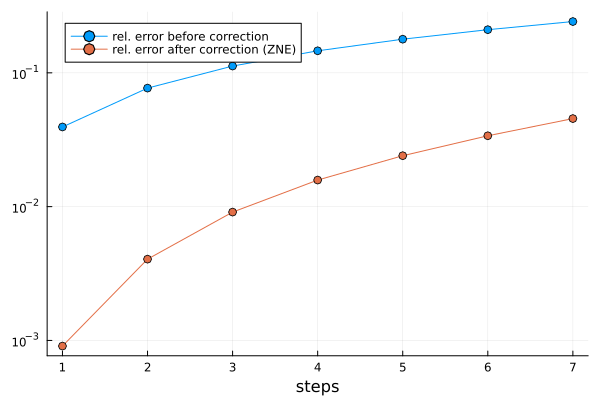

In [17]:
plot(1:trotter.steps, rel_before_zne[2:end], xlabel="steps", label="rel. error before correction", marker=:o)
plot!(1:trotter.steps, rel_after_zne[2:end], label="rel. error after correction (ZNE)", marker=:o, yscale=:log10)

# vnCDR
see Piotr 2021 for vnCDR implementation steps
-  for each circuit from the training data, calculate expectation value at multiple noise levels (e.g 1,1.2,1.5) and the corresponding noiseless expectation value
- vnCDR works with the varied noise levels of the training circuits, while ZNE works with the varied noise levels of the target circuit (implemented above)
- CPDR-ZNE described in the CPA paper is the same idea as vnCDR, but they allow for small angle perturbation from Cliffords and the use a Ridge Regression to reduce overfitting
- implement: vnCDR, which natively extends to CPDR -ZNE with linear regression
- add ridge regression as an option (self implemented, convex.jl, LinearRegressionKit.jl)

In [18]:
exact_expvals_training_levels = training_trotter_time_evolution(
    trotter,
    list_training_thetas;
    observable = observable,
    noise_kind = "noiseless",
    record = true
);

In [19]:
noisy_expvals_training_levels = vnCDR_training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, noise_kind="gate_ising", record = true);

Noisy expval at noise level 1.0: [[1.0, 0.9510220271043257, 0.886949453615349, 0.8117832563102169, 0.7298970586142574, 0.6456603526425356, 0.5631067780043703, 0.4856712341913566], [1.0, 0.9510220271043257, 0.8866842993711707, 0.8103119215432406, 0.7254025446213861, 0.6354607399813126, 0.5438511119970242, 0.45367400747213055], [1.0, 0.9510220271043257, 0.8866851930512152, 0.8103169068431392, 0.7254178856938218, 0.6354958824478381, 0.5439182159466615, 0.45378701007426564], [1.0, 0.9510220271043257, 0.8868142570079043, 0.8110350092485235, 0.7276197062895144, 0.6405164754539012, 0.5534514527926937, 0.4697359507698222], [1.0, 0.9510220271043257, 0.8872661278489116, 0.8135199682828202, 0.7351159089029702, 0.6572567586230456, 0.5844427860731555, 0.5200621362795232], [1.0, 0.9510220271043257, 0.8867156092363762, 0.8104864743011813, 0.7259392355111851, 0.6366888352066571, 0.5461930696848886, 0.4576117950034119], [1.0, 0.9510220271043257, 0.8870154596990996, 0.8121470895513144, 0.730998156946968

In [20]:
noisy_expvals_training_levels_end = noisy_expvals_training_levels[:,:,end]

3×10 Matrix{Float64}:
 0.485671  0.453674  0.453787  0.469736  …  0.537914  0.502357  0.498304
 0.460711  0.430909  0.431014  0.445868     0.509393  0.476256  0.47248
 0.425529  0.398745  0.398839  0.412187     0.46931   0.439505  0.436109

In [21]:
exact_expvals_training_end = [row[end] for row in exact_expvals_training]

10-element Vector{Float64}:
 0.6307692744523397
 0.5851836612154305
 0.5853447700158577
 0.608075241981989
 0.6796807910532593
 0.5907973349392583
 0.6414460864608191
 0.7050288552898768
 0.6545121311176979
 0.6487466974274789

In [37]:
pred, rel_after, rel_before = vnCDR(
    noisy_expvals_training_levels_end,
    exact_expvals_training_end,
    noisy_exp_last; exact_target_exp_value = exact_expval_target[end], use_target=true, lambda = 0.0
)

size and type of noisy_exp_values(3, 10)Matrix{Float64}
size and type of exact_exp_values(10,)Vector{Float64}
size and type of noisy_target_exp_value(3,)Vector{Float64}
size and type of exact_target_exp_value()Float64
X10×3 DataFrame
 Row │ x1        x2        x3       
     │ Float64   Float64   Float64  
─────┼──────────────────────────────
   1 │ 0.485671  0.460711  0.425529
   2 │ 0.453674  0.430909  0.398745
   3 │ 0.453787  0.431014  0.398839
   4 │ 0.469736  0.445868  0.412187
   5 │ 0.520062  0.492754  0.454342
   6 │ 0.457612  0.434576  0.40204
   7 │ 0.493173  0.4677    0.431811
   8 │ 0.537914  0.509393  0.46931
   9 │ 0.502357  0.476256  0.439505
  10 │ 0.498304  0.47248   0.436109
exact_exp_values[0.6307692744523397, 0.5851836612154305, 0.5853447700158577, 0.608075241981989, 0.6796807910532593, 0.5907973349392583, 0.6414460864608191, 0.7050288552898768, 0.6545121311176979, 0.6487466974274789]
params(coefs = [:x1 => 24.378298784748146, :x2 => -35.9858395986493, :x3 => 12.61

┌ Info: Training machine(LinearRegressor(fit_intercept = false, …), …).
└ @ MLJBase /home/julia/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: Analytical
│   iterative: Bool false
│   max_inner: Int64 200
└ @ MLJLinearModels /home/julia/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:27


(0.7678239025506253, 2.5522044860025992e-8, 0.3403064167540576)

In [34]:
## 1st method: computes only final vnCDR corrected value
function vnCDR(
    noisy_exp_values::Array{Float64,2},        # size (m circuits, n+1 noise levels)
    exact_exp_values::Vector{Float64},         # size m
    noisy_target_exp_value::Vector{Float64};  # size n+1
    exact_target_exp_value::Union{Nothing, Float64}=nothing,
    use_target::Bool=true,
    lambda::Float64=0.0                         # regularization strength
)
    println("size and type of noisy_exp_values", size(noisy_exp_values), typeof(noisy_exp_values))
    println("size and type of exact_exp_values", size(exact_exp_values), typeof(exact_exp_values))
    println("size and type of noisy_target_exp_value", size(noisy_target_exp_value), typeof(noisy_target_exp_value))
    println("size and type of exact_target_exp_value", size(exact_target_exp_value), typeof(exact_target_exp_value))
    model = lambda == 0.0 ? LinearRegressor(fit_intercept = false) : RidgeRegressor(lambda=lambda,fit_intercept = false)


    # Convert input matrix to DataFrame
    X = DataFrame(noisy_exp_values', :auto)

    println("X", X)
    println("exact_exp_values", exact_exp_values)
    mach = machine(model, X, exact_exp_values)
    fit!(mach)
    params = fitted_params(mach)
    println("params", params)

    # Manually compute prediction
    coefs = [v for (_, v) in fitted_params(mach).coefs]
    println("coefs", coefs)
    println("noisy_target_exp_value", noisy_target_exp_value)   
    pred = coefs'* noisy_target_exp_value
    println("pred" , pred)
    
    if use_target && exact_target_exp_value !== nothing
        rel_error_after = abs(exact_target_exp_value - pred) / abs(exact_target_exp_value)
        rel_error_before = abs(exact_target_exp_value - noisy_target_exp_value[end]) / abs(exact_target_exp_value)
        return pred, rel_error_after, rel_error_before
    else
        return pred
    end
end

vnCDR (generic function with 1 method)

In [35]:
#2nd method: vnCDR for every step
function vnCDR_out(
    noisy_exp_values::Array{Float64,3},  # (matrix) from via vnCDR_training_trotter_time_evolution      # size (n+1 noise levels, m circuits, t+1 steps)
    exact_exp_values::Vector{Vector{Float64}},  # from  trotter_time_evolution!!
    noisy_target_exp_value::Array{Float64,2}; # (matrix) from zne_time_evolution
    exact_target_exp_value::Union{Nothing, Vector{Float64}}=nothing,
    use_target::Bool=true,
    lambda::Float64=0.0
)
    println("size exact_exp_vals ",size(exact_exp_values))
    nsteps = size(noisy_exp_values, 3)

    println("nsteps" , nsteps)
    corrected = Vector{Float64}(undef, nsteps)
    rel_errors_after = Float64[] # vector 
    rel_errors_before = Float64[] 
    for i in 1:nsteps
        println("size 1st argument ",size(transpose(noisy_exp_values[:, :, i])))
        println("type of noisy_exp_values[:,:,i]",typeof(noisy_exp_values[:, :, i]))
        println(typeof(exact_exp_values[i]))
        println("type of noisy target exp value ",typeof(noisy_target_exp_value[i]))
        println(typeof(exact_target_exp_value[i]))

        println("perm ",size(permutedims(noisy_exp_values[:, :, i], (2, 1))))
        result = vnCDR(
        permutedims(noisy_exp_values[:, :, i], (2, 1)),
        exact_exp_values[i],
        noisy_target_exp_value[:,i];
        exact_target_exp_value = use_target ? (exact_target_exp_value === nothing ? nothing : exact_target_exp_value[i]) : nothing,
        use_target = use_target,
        lambda = lambda
    )

        

        if use_target && exact_target_exp_value !== nothing
            corrected[i], err_after, err_before = result
            push!(rel_errors_after, err_after)
            push!(rel_errors_before, err_before)
        else
            corrected[i] = result
        end
    end

    return use_target ? (corrected, rel_errors_after, rel_errors_before) : corrected
end

vnCDR_out (generic function with 1 method)

In [36]:
#test 
println("noisy_expvals_training_levels ", size(noisy_expvals_training_levels), typeof(noisy_expvals_training_levels)) #(3,10,8) 
println("exact_expvals_training ", size(exact_expvals_training),typeof(exact_expvals_training)) #(10,8)
#println("exact_expvals_training" , exact_expvals_training, typeof(exact_expvals_training)) # 10x8 matrix
println("noisy_expval_target_levels ", size(noisy_expval_target_levels), typeof(noisy_expval_target_levels)) #(3,8)
println("exact_expval_target ", size(exact_expval_target), typeof(exact_expval_target)) #(8,)

corr, rel_after, rel_before = vnCDR_out(
    noisy_expvals_training_levels,
    exact_expvals_training,
    noisy_expval_target_levels; exact_target_exp_value = exact_expval_target, use_target=true
)

noisy_expvals_training_levels (3, 10, 8)Array{Float64, 3}
exact_expvals_training (10,)Vector{Vector{Float64}}
noisy_expval_target_levels (3, 8)Matrix{Float64}
exact_expval_target (8,)Vector{Float64}
size exact_exp_vals (10,)
nsteps8
size 1st argument (10, 3)
type of noisy_exp_values[:,:,i]Matrix{Float64}
Vector{Float64}
type of noisy target exp value Float64
Float64
perm (10, 3)
size and type of noisy_exp_values(10, 3)Matrix{Float64}
size and type of exact_exp_values(8,)Vector{Float64}
size and type of noisy_target_exp_value(3,)Vector{Float64}
size and type of exact_target_exp_value()Float64
X3×10 DataFrame
 Row │ x1       x2       x3       x4       x5       x6       x7       x8       x9       x10     
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │     1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.0      1.

DimensionMismatch: DimensionMismatch: Differing number of observations in input and target. 